In [1]:
import pickle
import numpy as np
import keras
import pandas as pd 
from keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

## Read Scrapped Tweets

In [2]:
#input from scrapping tweets in list format 
data = pd.read_csv('tweets_starbucks2.csv')
data = data[~data['user'].str.contains('user')]
date_tweets=data["time"].to_list()
original_tweets=data.text.to_list()


## PreProcessing

In [3]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

punctuations_and_dummies = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# preprocess function
def preprocess(tweet, will_be_stemmed=False):
    tweet = re.sub(punctuations_and_dummies, ' ', str(tweet).lower()).strip()
    tokens = []
    for token in tweet.split():
        if token not in stop_words:
            if will_be_stemmed:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
processed_tweets = [preprocess(tweet) for tweet in original_tweets]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print(original_tweets)
print(processed_tweets)

['starbucks is not even on BDS list… why does no one do any research of their own? you can tell who is being performative for clicks… boycott them bc they treat their union workers like garbage and maybe not call ppl who work at/drink starbucks genocide supporters???', 'The @PureGym leadership won’t be taking this reaction lightly. Just need to look at Starbucks and their tanking in share price to see the power of boycotting', 'Billie Eilish went to Starbucks after wearing a pro Palestine pin at the Grammies and no one batted an eye, Gigi Hadid who’s Palestinian herself has been seen with a Starbucks and no one cared , Starbucks isn’t on the boycott list either!! Why don’t yall admit you hate Selena', 'My dear brothers , sisters, friends, and followers ATTENTION PLEASE Many of you don’t know that many brands are in support of Israel boycotting them will create loss to their business many Starbucks branches have shut. Let’s start a boycott campaign join the act #boycott', 'Making lists 

## AI Model

In [5]:
model = keras.models.load_model('old_model_sentiment_v1.h5')

for layer in model.layers:
    layer.trainable = False

# Modify the model architecture for fine-tuning
x = model.layers[-2].output
predictions = Dense(units=2, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

config = pickle.load(open('config.pkl', 'rb'))
def predict_sentiment(text_list, model, config):
    predictions = []
    tokenizer = config['tokenizer']['tokenizer']
    for text in text_list:
        text_sequences = tokenizer.texts_to_sequences([text])
        padded_sequences = pad_sequences(text_sequences, maxlen=config['tokenizer']['token_maxlen'],
                                         padding=config['tokenizer']['padding_type'],
                                         truncating=config['tokenizer']['truncating_type'],
                                         value=config['tokenizer']['padding_value'])
        sentiment = model.predict(padded_sequences, batch_size=1, verbose=0)[0]
        argmax_sent = np.argmax(sentiment)
        sentiment_text = 'Positive' if argmax_sent == 1 else 'Negative'
        sentiment_score = sentiment[argmax_sent]
        predictions.append((sentiment_text, sentiment_score))
    return predictions

# to call function 
sentiment=predict_sentiment(processed_tweets, model, config)
print(sentiment)

[('Negative', 0.51477367), ('Negative', 0.53243285), ('Negative', 0.5316865), ('Negative', 0.53594327), ('Positive', 0.51016045), ('Negative', 0.576404), ('Negative', 0.60682595), ('Negative', 0.59470475), ('Positive', 0.56864464), ('Positive', 0.5344039), ('Negative', 0.5065021), ('Positive', 0.5550628), ('Negative', 0.6329682), ('Negative', 0.5792588), ('Positive', 0.55685085), ('Negative', 0.5537923), ('Positive', 0.528942), ('Negative', 0.53202695), ('Negative', 0.58141404), ('Negative', 0.5740696), ('Negative', 0.58803517), ('Positive', 0.5428879), ('Positive', 0.53973323), ('Negative', 0.61083925), ('Negative', 0.55529636), ('Positive', 0.531107), ('Positive', 0.5158233), ('Positive', 0.5050456), ('Positive', 0.56034994), ('Negative', 0.55664545), ('Positive', 0.5155677), ('Negative', 0.5976816), ('Negative', 0.59695345), ('Negative', 0.5802685), ('Positive', 0.5020086), ('Negative', 0.54929185), ('Negative', 0.53470784), ('Negative', 0.5802685), ('Positive', 0.5020086), ('Negati

In [6]:
# to convert list items in sentiment elements from tuple to list 
mapped_results=[]
for i in sentiment:
  mapped_results.append(list(i))
for i in range(len(original_tweets)):
  mapped_results[i].append(original_tweets[i])
  mapped_results[i].append(date_tweets[i])
print(mapped_results)

[['Negative', 0.51477367, 'starbucks is not even on BDS list… why does no one do any research of their own? you can tell who is being performative for clicks… boycott them bc they treat their union workers like garbage and maybe not call ppl who work at/drink starbucks genocide supporters???', '2024-05-10T23:22:04.000Z'], ['Negative', 0.53243285, 'The @PureGym leadership won’t be taking this reaction lightly. Just need to look at Starbucks and their tanking in share price to see the power of boycotting', '2024-05-10T15:47:36.000Z'], ['Negative', 0.5316865, 'Billie Eilish went to Starbucks after wearing a pro Palestine pin at the Grammies and no one batted an eye, Gigi Hadid who’s Palestinian herself has been seen with a Starbucks and no one cared , Starbucks isn’t on the boycott list either!! Why don’t yall admit you hate Selena', '2024-05-04T16:58:00.000Z'], ['Negative', 0.53594327, 'My dear brothers , sisters, friends, and followers ATTENTION PLEASE Many of you don’t know that many b

## Pie Chart (Requirement 1)

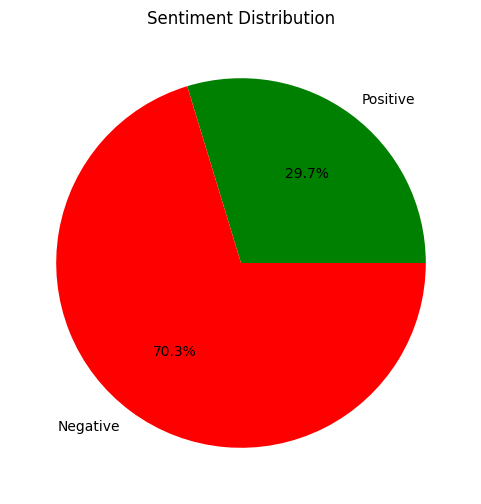

In [7]:
# to get positive and negative pct 
def percentage(tweet_lst):
  positive_count = sum(1 for item in tweet_lst if item[0] == 'Positive')
  negative_count = sum(1 for item in tweet_lst if item[0] == 'Negative')
  positive_pct= positive_count/len(tweet_lst)
  negative_pct = negative_count/len(tweet_lst)
  return f'positive percentage ={positive_pct} , negative percentage ={negative_pct}'

# Pie Chart (Requirement 1)
percentage(mapped_results)

# Drawing pie chart of percentage of positve and negative 
def pie_chart(tweet_lst):
  sentiments = [item[0] for item in tweet_lst]
  plt.figure(figsize=(6, 6))
  plt.pie([sentiments.count('Positive'), sentiments.count('Negative')], labels=['Positive', 'Negative'], autopct='%1.1f%%', colors=['green', 'red'])
  plt.title('Sentiment Distribution')
  plt.show()

pie_chart(mapped_results)

## Sample Tweets (Requirement 2)

In [8]:
#to get trend of this tweets [get two high score]
def get_high_score(tweet_lst):
    sorted_data = sorted(tweet_lst, key=lambda x: x[1], reverse=True)
    positive=[]
    negative=[]
    for i in range(len(tweet_lst)):
      if tweet_lst[i][0] == 'Positive':
        positive.append(tweet_lst[i])
      else:
        negative.append(tweet_lst[i])
    
    return sorted(positive,reverse=True)[:2],sorted(negative,reverse=True)[:2]

# Sample Tweets (Requirement 2)
get_high_score(mapped_results)

([['Positive',
   0.56864464,
   "We have been great at boycotting McDonald's and Starbucks and Pure Gym is next. Which other Israeli-supporting companies must we boycott?",
   '2024-05-10T11:30:57.000Z'],
  ['Positive',
   0.56034994,
   'Starbucks + cats = easy money Don’t fade $STRBCT Join us: https://linktr.ee/starbuckscat',
   '2024-05-11T15:38:17.000Z']],
 [['Negative',
   0.6329682,
   "I've just cancelled my PureGym membership after 4 years. Not supporting a company with a CEO who supports genocide and ethnic cleansing. Hope you're ready for the economic loss that Starbucks has had over the last several months @PureGym Free Palestine.",
   '2024-05-11T12:09:33.000Z'],
  ['Negative',
   0.61083925,
   'I’m sorry but it’s absolutely fucking ridiculous to claim that someone is a Z*onist for these reasons (the organizations she’s “supporting” is literally just her being photographed near a Starbucks)',
   '2024-05-11T23:08:22.000Z']])

## Trend (Requirement 3)

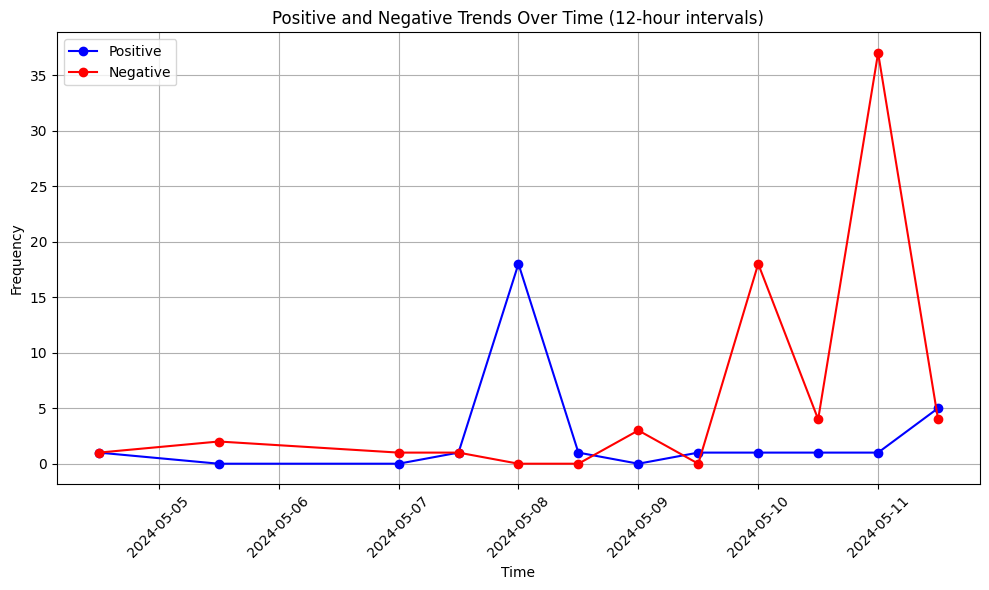

time
2024-05-04 12:00:00+00:00     1.0
2024-05-05 12:00:00+00:00     0.0
2024-05-07 00:00:00+00:00     0.0
2024-05-07 12:00:00+00:00     1.0
2024-05-08 00:00:00+00:00    18.0
2024-05-08 12:00:00+00:00     1.0
2024-05-09 00:00:00+00:00     0.0
2024-05-09 12:00:00+00:00     1.0
2024-05-10 00:00:00+00:00     1.0
2024-05-10 12:00:00+00:00     1.0
2024-05-11 00:00:00+00:00     1.0
2024-05-11 12:00:00+00:00     5.0
Name: Positive, dtype: float64
time
2024-05-04 12:00:00+00:00     1.0
2024-05-05 12:00:00+00:00     2.0
2024-05-07 00:00:00+00:00     1.0
2024-05-07 12:00:00+00:00     1.0
2024-05-08 00:00:00+00:00     0.0
2024-05-08 12:00:00+00:00     0.0
2024-05-09 00:00:00+00:00     3.0
2024-05-09 12:00:00+00:00     0.0
2024-05-10 00:00:00+00:00    18.0
2024-05-10 12:00:00+00:00     4.0
2024-05-11 00:00:00+00:00    37.0
2024-05-11 12:00:00+00:00     4.0
Name: Negative, dtype: float64


In [9]:
def trend(tweet_lst):
    # Convert tweet_lst to DataFrame
    df = pd.DataFrame(tweet_lst, columns=['Sentiment', 'Score', 'Text', 'time'])
    
    # Convert 'time' column to datetime
    # df['time'] = pd.to_datetime(df['time'])
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M:%S.%f%z')

    
    # Sort DataFrame by 'time'
    df = df.sort_values(by='time')
    
    # Resample data to every 12 hours and count positive and negative occurrences
    df_resampled = df.resample('12H', on='time')['Sentiment'].value_counts().unstack().fillna(0)
    
    # Plotting both trends in the same graph
    plt.figure(figsize=(10, 6))

    # Positive trend
    plt.plot(df_resampled.index, df_resampled['Positive'], marker='o', color='b', linestyle='-', label='Positive')
    # Negative trend
    plt.plot(df_resampled.index, df_resampled['Negative'], marker='o', color='r', linestyle='-', label='Negative')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Positive and Negative Trends Over Time (12-hour intervals)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # trend (Requirement 3)
    print(df_resampled['Positive'])
    print(df_resampled['Negative'])

trend(mapped_results)


## Word Cloud (Requierment 4)

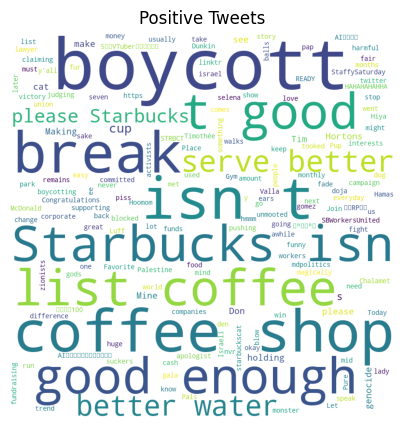

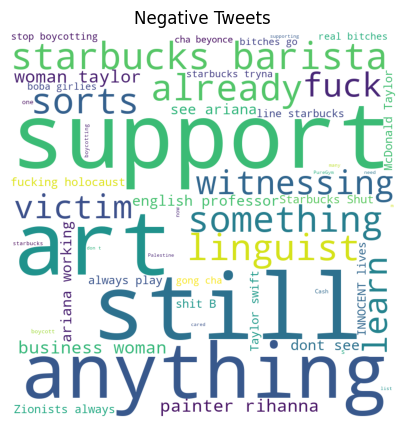

In [10]:
# to get wordcloud for each positive and negative tweets 
def get_wordcloud(tweet_lst):
  positive_tweets = [item[2] for item in tweet_lst if item[0] == 'Positive']
  negative_tweets = [item[2] for item in tweet_lst if item[0] == 'Negative']
  # Generate word cloud for positive tweets
  positive_text = " ".join(positive_tweets)
  positive_wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  stopwords = None, 
                  min_font_size = 10).generate(positive_text)
  # Generate word cloud for positive tweets
  negative_text = " ".join(negative_tweets)
  negative_wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  stopwords = None, 
                  min_font_size = 10).generate(negative_text)
  # Plot the word clouds for positive tweets
  plt.figure(figsize=(10, 5))
  plt.imshow(positive_wordcloud)
  plt.title('Positive Tweets')
  plt.axis('off')
  plt.show()
    # Plot the word clouds for negative tweets
  plt.figure(figsize=(10, 5))
  plt.imshow(negative_wordcloud)
  plt.title('Negative Tweets')
  plt.axis('off')
  plt.show()

# Word Cloud (Requierment 4)
get_wordcloud(mapped_results)